# [IAPR][iapr]: Lab 1 ‒  Image segmentation


**Group ID:** 17

**Author 1 (sciper):** Ben Haj Yahia AHMED (261317)  
**Author 2 (sciper):** Student Name 2 (xxxxx)   
**Author 3 (sciper):** Student Name 3 (xxxxx)   

**Release date:** 12.03.2021  
**Due date:** 26.03.2021 


## Important notes

The lab assignments are designed to teach practical implementation of the topics presented during class well as preparation for the final project, which is a practical project which ties together the topics of the course. 

As such, in the lab assignments/final project, unless otherwise specified, you may, if you choose, use external functions from image processing/ML libraries like opencv and sklearn as long as there is sufficient explanation in the lab report. For example, you do not need to implement your own edge detector, etc.

**! Before handling back the notebook !** rerun the notebook from scratch `Kernel` > `Restart & Run All`


[iapr]: https://github.com/LTS5/iapr

---
## 0. Extract relevant data
We first need to extract the `lab-01-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [1]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-01-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')

if not os.path.exists(tar_path):
    raise Exception('Path to is not valid {}'.format(tar_path))
    
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

---
## Part 1: Brain segmentation

Your goal: compute the size of the brain (without the skull) in pixels in a 2D image of a human head taken by Magnetic Resonance Imaging (MRI) using:
* Region growing (5 pts)
* Contour detection (5 pts)
* Additional method of your choice (5 pts)

Each section should display the resulting segmenttion as well as the size in pixel of the detected region. Comment each method limitations and/or advantages.

### 1.1 Brain image visualization

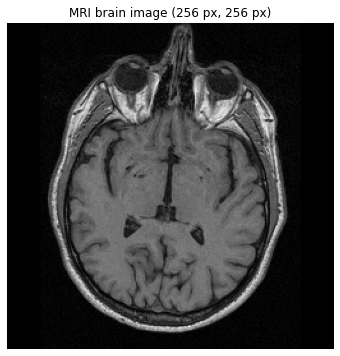

In [44]:
import skimage.io
import matplotlib.pyplot as plt
%matplotlib inline

# Load image
data_path = os.path.join(data_base_path, data_folder)
brain_im_path = os.path.join(data_path, 'brain-slice40.tiff')
brain_im = skimage.io.imread(brain_im_path)
im_h, im_w = brain_im.shape

# Display MRI image
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(brain_im, cmap='gray')
ax.set_title('MRI brain image ({} px, {} px)'.format(im_h, im_w))
ax.axis('off')
plt.show()

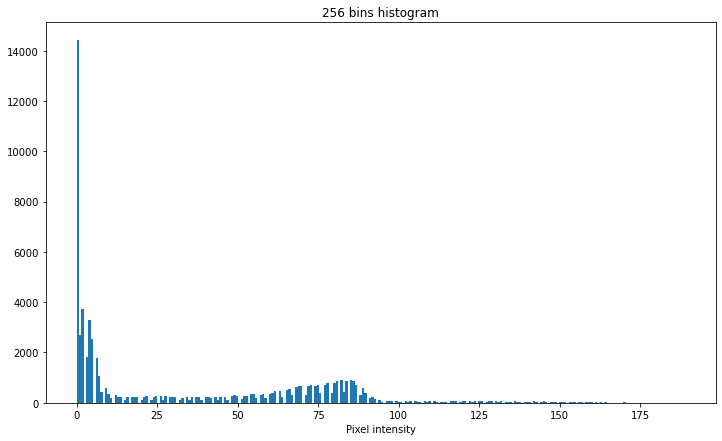

In [45]:
nb_bins = 256

# Display histogram
plt.figure(figsize=(12, 7))
plt.hist(brain_im.ravel(), bins=nb_bins)
plt.xlabel('Pixel intensity')
plt.title('256 bins histogram')

plt.show()

### 1.2 Region growing (5pts)

The Watershed from sklearn library has a function (skimage.morphology.watershed()) that implements a region-growing approach that fills “basins” in the image. We choose to use it here.

In [343]:
from skimage import measure 
from skimage.exposure import histogram
import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import clear_border, watershed
from scipy import ndimage as ndi
from skimage.filters.rank import median
from skimage.morphology import disk

In [372]:
markers = np.zeros_like(brain_im)
markers[brain_im < 12.5] = 1
markers[brain_im > 65] = 2
markers[brain_im > 85] = 1

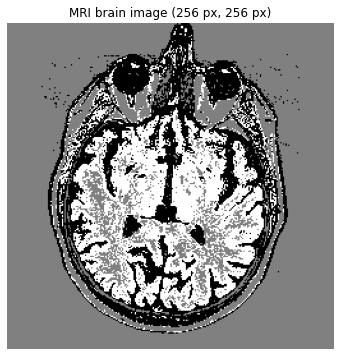

In [373]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(markers, cmap='gray')
ax.set_title('MRI brain image ({} px, {} px)'.format(im_h, im_w))
ax.axis('off')
plt.show()

In [374]:
segmentation = watershed(brain_im, markers)


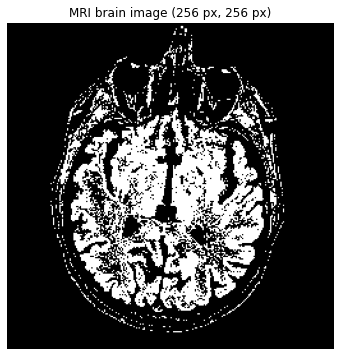

In [375]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(segmentation, cmap='gray')
ax.set_title('MRI brain image ({} px, {} px)'.format(im_h, im_w))
ax.axis('off')
plt.show()

In [376]:
segmentation = ndi.binary_fill_holes(segmentation - 1)

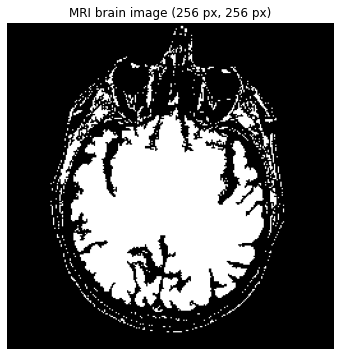

In [377]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(segmentation, cmap='gray')
ax.set_title('MRI brain image ({} px, {} px)'.format(im_h, im_w))
ax.axis('off')
plt.show()

/home/nabegh/Anaconda3/envs/kaggle/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3437: UserWarning: Possible precision loss converting image of type float64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


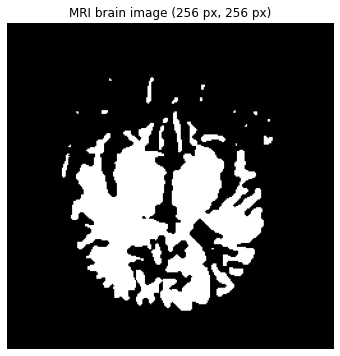

In [378]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(median(segi.astype('float64'), disk(2)), cmap='gray')
ax.set_title('MRI brain image ({} px, {} px)'.format(im_h, im_w))
ax.axis('off')
plt.show()

In [379]:
segi = ndi.binary_fill_holes(median(segmentation.astype('float64'), disk(2)))

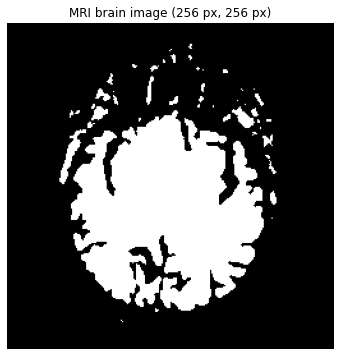

In [380]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(segi, cmap='gray')
ax.set_title('MRI brain image ({} px, {} px)'.format(im_h, im_w))
ax.axis('off')
plt.show()

In [381]:
segi.sum()

16665

Internal Marker


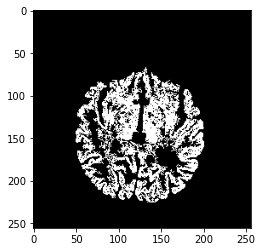

External Marker


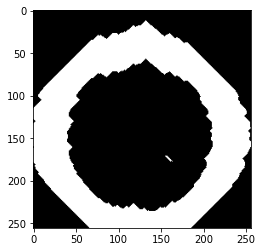

Watershed Marker


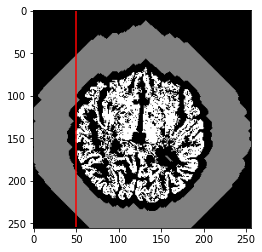

In [382]:
# Some of the starting Code is taken from ArnavJain, since it's more readable then my own
def generate_markers(image):
    #Creation of the internal Marker
    marker_internal = (image > 65) & (image < 85)
    marker_internal = clear_border(marker_internal)
    marker_internal_labels = measure.label(marker_internal)
    areas = [r.area for r in measure.regionprops(marker_internal_labels)]
    areas.sort()
    if len(areas) > 2:
        for region in measure.regionprops(marker_internal_labels):
            if region.area < areas[-2]:
                for coordinates in region.coords:                
                       marker_internal_labels[coordinates[0], coordinates[1]] = 0
    marker_internal = marker_internal_labels > 0
    #Creation of the external Marker
    external_a = ndi.binary_dilation(marker_internal, iterations=10)
    external_b = ndi.binary_dilation(marker_internal, iterations=55)
    marker_external = external_b ^ external_a
    #Creation of the Watershed Marker matrix
    marker_watershed = np.zeros((256, 256), dtype=np.int)
    marker_watershed += marker_internal * 255
    marker_watershed += marker_external * 128
    
    return marker_internal, marker_external, marker_watershed

#Show some example markers from the middle        
test_patient_internal, test_patient_external, test_patient_watershed = generate_markers(brain_im)
print ("Internal Marker")
plt.imshow(test_patient_internal, cmap='gray')
plt.show()
print ("External Marker")
plt.imshow(test_patient_external, cmap='gray')
plt.show()
print ("Watershed Marker")
plt.imshow(test_patient_watershed, cmap='gray')
plt.vlines(50, color='red', ymin=0, ymax=255)
plt.show()

Sobel Gradient


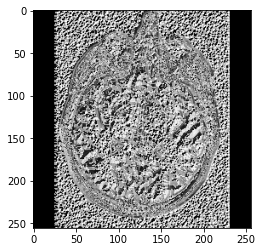

Watershed Image


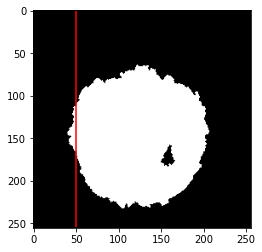

Outline after reinclusion


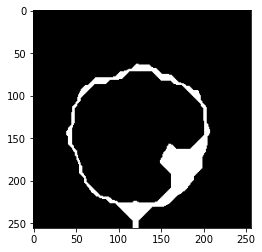

Lungfilter after closing


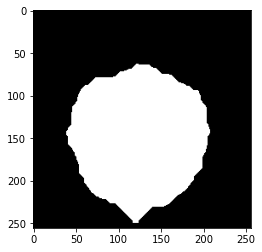

Segmented Lung


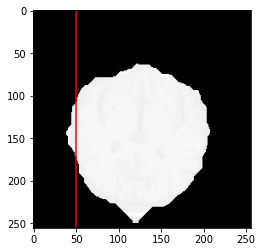

In [388]:
def seperate_lungs(image):
    #Creation of the markers as shown above:
    marker_internal, marker_external, marker_watershed = generate_markers(image)
    
    #Creation of the Sobel-Gradient
    sobel_filtered_dx = ndi.sobel(image, 1)
    sobel_filtered_dy = ndi.sobel(image, 0)
    sobel_gradient = np.hypot(sobel_filtered_dx, sobel_filtered_dy)
    sobel_gradient *= 255.0 / np.max(sobel_gradient)
    
    #Watershed algorithm
    watershed_res = watershed(sobel_gradient, marker_watershed)
    
    #Reducing the image created by the Watershed algorithm to its outline
    outline = ndi.morphological_gradient(watershed_res, size=(3,3))
    outline = outline.astype(bool)
    
    #Performing Black-Tophat Morphology for reinclusion
    #Creation of the disk-kernel and increasing its size a bit
    blackhat_struct = [[0, 0, 1, 1, 1, 0, 0],
                       [0, 1, 1, 1, 1, 1, 0],
                       [1, 1, 1, 1, 1, 1, 1],
                       [1, 1, 1, 1, 1, 1, 1],
                       [1, 1, 1, 1, 1, 1, 1],
                       [0, 1, 1, 1, 1, 1, 0],
                       [0, 0, 1, 1, 1, 0, 0]]
    blackhat_struct = ndi.iterate_structure(blackhat_struct, 8)
    #Perform the Black-Hat
    outline += ndi.black_tophat(outline, structure=blackhat_struct)
    
    #Use the internal marker and the Outline that was just created to generate the lungfilter
    lungfilter = np.bitwise_or(marker_internal, outline)
    #Close holes in the lungfilter
    #fill_holes is not used here, since in some slices the heart would be reincluded by accident
    lungfilter = ndi.morphology.binary_closing(lungfilter, structure=np.ones((5,5)), iterations=3)
    
    #Apply the lungfilter (note the filtered areas being assigned -2000 HU)
    segmented = np.where(lungfilter == 1, image, -2000*np.ones((256, 256)))
    
    return segmented, lungfilter, outline, watershed_res, sobel_gradient, marker_internal, marker_external, marker_watershed

#Some Testcode:
test_segmented, test_lungfilter, test_outline, test_watershed, test_sobel_gradient, test_marker_internal, test_marker_external, test_marker_watershed = seperate_lungs(brain_im)

print ("Sobel Gradient")
plt.imshow(np.rint(test_sobel_gradient).astype(int), cmap='gray')
plt.show()
print ("Watershed Image")
plt.imshow(test_watershed, cmap='gray')
plt.vlines(50, color='red', ymin=0, ymax=255)
plt.show()
print ("Outline after reinclusion")
plt.imshow(test_outline, cmap='gray')
plt.show()
print ("Lungfilter after closing")
plt.imshow(test_lungfilter, cmap='gray')
plt.show()
print ("Segmented Lung")
plt.imshow(test_segmented, cmap='gray')
plt.vlines(50, color='red', ymin=0, ymax=255)
plt.show()

In [393]:
test_watershed = ndi.binary_fill_holes(test_watershed)

Watershed Image


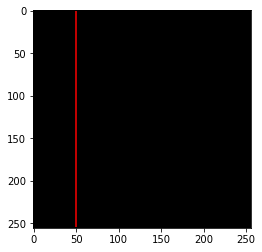

In [394]:
print ("Watershed Image")
plt.imshow((test_watershed == 255), cmap='gray')
plt.vlines(50, color='red', ymin=0, ymax=255)
plt.show()

In [395]:
(test_watershed == 255).sum()

0

### 1.3 Contour detection (5pts)

# Add your implementation and discussion

--> I think we need to preprocess the Image before applying the canny edge but I coulnd't find the appropriate preprocessing steps

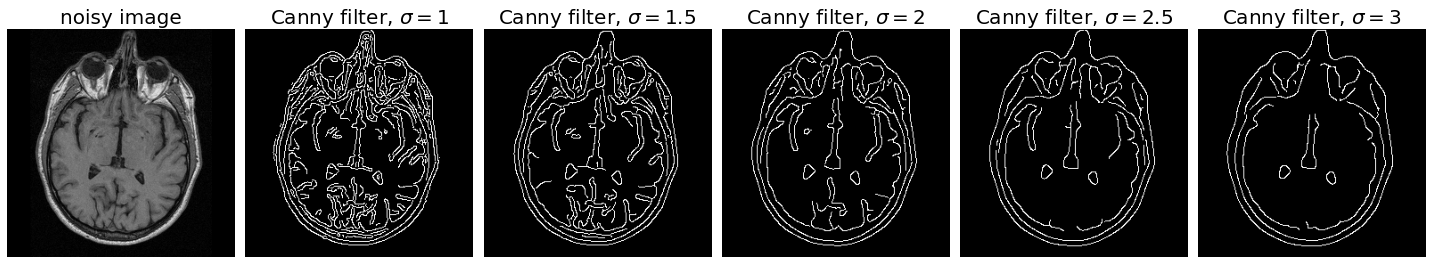

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi

from skimage import feature


# Compute the Canny filter for two values of sigma
edges1 = feature.canny(brain_im)
edges2 = feature.canny(brain_im,sigma=1.5)
edges3 = feature.canny(brain_im,sigma=2)
edges4 = feature.canny(brain_im,sigma=2.5)
edges5 = feature.canny(brain_im, sigma=3)

# display results
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(nrows=1, ncols=6, figsize=(20, 10),
                                    sharex=True, sharey=True)

ax1.imshow(brain_im, cmap=plt.cm.gray)
ax1.axis('off')
ax1.set_title('noisy image', fontsize=20)

ax2.imshow(edges1, cmap=plt.cm.gray)
ax2.axis('off')
ax2.set_title(r'Canny filter, $\sigma=1$', fontsize=20)

ax3.imshow(edges2, cmap=plt.cm.gray)
ax3.axis('off')
ax3.set_title(r'Canny filter, $\sigma=1.5$', fontsize=20)

ax4.imshow(edges3, cmap=plt.cm.gray)
ax4.axis('off')
ax4.set_title(r'Canny filter, $\sigma=2$', fontsize=20)

ax5.imshow(edges4, cmap=plt.cm.gray)
ax5.axis('off')
ax5.set_title(r'Canny filter, $\sigma=2.5$', fontsize=20)

ax6.imshow(edges5, cmap=plt.cm.gray)
ax6.axis('off')
ax6.set_title(r'Canny filter, $\sigma=3$', fontsize=20)

fig.tight_layout()

plt.show()

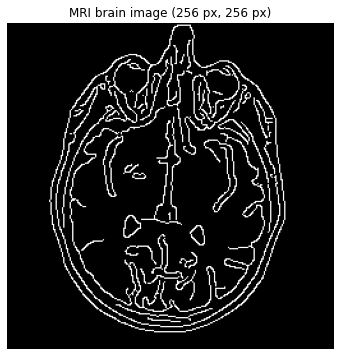

In [15]:
# Display best canny filter
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(edges2, cmap='gray')
ax.set_title('MRI brain image ({} px, {} px)'.format(im_h, im_w))
ax.axis('off')
plt.show()

### finding appropriate preprocessing steps

In [16]:
import skimage as skimage
import skimage.viewer

/home/nabegh/Anaconda3/envs/kaggle/lib/python3.7/site-packages/skimage/viewer/utils/__init__.py:1: UserWarning: Recommended matplotlib backend is `Agg` for full skimage.viewer functionality.
  from .core import *


In [17]:
def filter_function(image, sigma, threshold1, threshold2):
    masked = image.copy()
    masked[skimage.filters.gaussian(image, sigma=sigma) <= threshold1] = 0
    masked[skimage.filters.gaussian(image, sigma=sigma) >= threshold2] = 0

    return masked


smooth_threshold_plugin = skimage.viewer.plugins.Plugin(
    image_filter=filter_function
)

smooth_threshold_plugin.name = "Smooth and Threshold Plugin"

smooth_threshold_plugin += skimage.viewer.widgets.Slider(
    "sigma", low=0.0, high=7.0, value=1.0
)
smooth_threshold_plugin += skimage.viewer.widgets.Slider(
    "threshold1", low=0.0, high=1.0, value=0.5
)

smooth_threshold_plugin += skimage.viewer.widgets.Slider(
    "threshold2", low=0.0, high=1.0, value=0.5
)

image = brain_im.copy()

viewer = skimage.viewer.ImageViewer(image=image)
viewer += smooth_threshold_plugin
viewer.show()

/home/nabegh/Anaconda3/envs/kaggle/lib/python3.7/site-packages/ipykernel_launcher.py:28: FutureWarning: `viewer` is deprecated and will be removed in 0.20. For alternatives, refer to https://scikit-image.org/docs/stable/user_guide/visualization.html


[(array([[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
  None)]

In [18]:
# [0.7 , 0.21, 0.33]

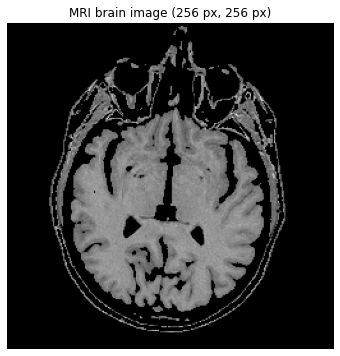

In [19]:
filtered = filter_function(brain_im,0.9,0.21,0.36)
# Display best canny filter
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(filtered, cmap='gray')
ax.set_title('MRI brain image ({} px, {} px)'.format(im_h, im_w))
ax.axis('off')
plt.show()

### 1.4 Additional method (5pts)

In [20]:
import skimage.filters as filters
import skimage.segmentation as seg


In [21]:
def image_show(image, nrows=1, ncols=1, cmap='gray'):
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(8, 8))
    ax.imshow(image, cmap='gray')
    ax.axis('off')
    return fig, ax

In [22]:
def circle_points(resolution, center, radius):
    """
    Generate points which define a circle on an image.Centre refers to the centre of the circle
    """   
    radians = np.linspace(0, 2*np.pi, resolution)
    c = center[1] + radius*np.cos(radians)#polar co-ordinates
    r = center[0] + radius*np.sin(radians)
    
    return np.array([c, r]).T
# Exclude last point because a closed path should not have duplicate points
points = circle_points(200, [150, 125], 80)[:-1]

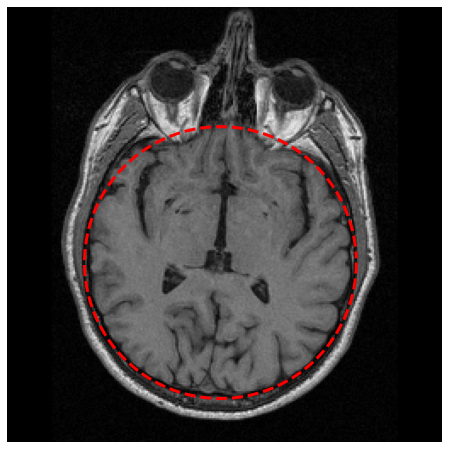

In [23]:
fig, ax = image_show(brain_im)
ax.plot(points[:, 0], points[:, 1], '--r', lw=3)

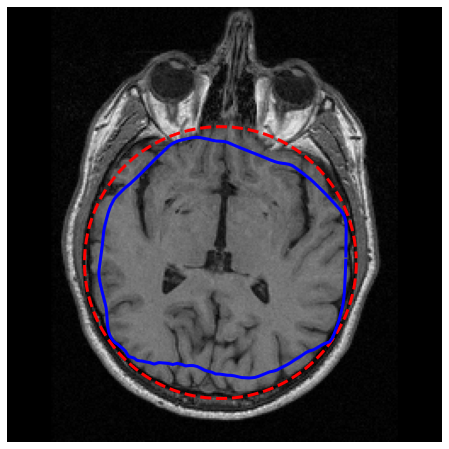

In [24]:
snake = seg.active_contour(brain_im, points, alpha=0.1,beta=0.2)
fig, ax = image_show(brain_im)
ax.plot(points[:, 0], points[:, 1], '--r', lw=3)
ax.plot(snake[:, 0], snake[:, 1], '-b', lw=3);

---
## Part 2: Shape/color segmentation

You will find hereafter three pictures taken under three different illuminations, containing some shapes with different colors. We ask you to create a routine to:

1. Count the number of shapes of each color (5pts).
2. Compute the total area (in pixels) of each color (5pts).

Please note that one specific challenge is to be robust to illumination changes. Therefore some kind of intensity normalization should probably be used.

### 2.1 Visualization

In [25]:
# Load images
im_names = ['arena-shapes-01', 'arena-shapes-02', 'arena-shapes-03']
filenames = [os.path.join(data_path, name) + '.png' for name in im_names]
ic = skimage.io.imread_collection(filenames)
images = skimage.io.concatenate_images(ic)
print('Number of images: ', images.shape[0])
print('Image size: {}, {} '.format(images.shape[1], images.shape[2]))
print('Number of color channels: ', images.shape[-1])

Number of images:  3
Image size: 480, 640 
Number of color channels:  3


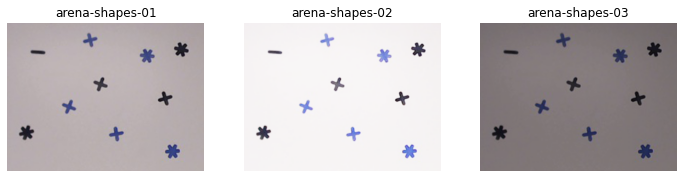

In [26]:
# Plot images
fig, axes = plt.subplots(1, 3, figsize=(12, 12))
for ax, im, nm in zip(axes.ravel(), images, im_names):
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(nm)
plt.show()

### 2.2 Number of shapes of each color (5 pts)

In [27]:
# Add your implementation and discussion

### 2.3 Total area (in pixels) of each color (5 pts)

In [28]:
# Add your implementation and discussion